In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

# Define sensor and source space

In [2]:
n_t = 200
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0,0,0]])
for i in range(J.shape[-1]-1):
    J[:, i+1] = np.dot(A, J[:, i])



# Ground truth

(0, 200)

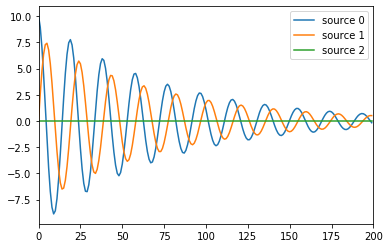

In [3]:
plt.plot(J.T)
plt.legend(['source %s'%s for s in range(n_s)])
plt.xlim(0, n_t)

# Define the structural connectivity

In [4]:
SC = np.array([[1,1,1], [1,1,0],[0,1,1]])
print( SC)

[[1 1 1]
 [1 1 0]
 [0 1 1]]


# Example 1: iSDR order 1

## Generate EEG/MEG data

In [5]:
m_p = 1
M = np.dot(G, J[:, m_p:])

## Run ISDR

In [6]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=[1e-3, 1.0])
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s))
R = cl.coef_

## Get eigenvalues of MVAR model

In [7]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.937373,0.314642
eig_1,0.937373,-0.314642


## Plot effective connectivity

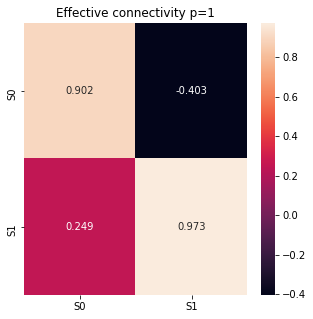

In [8]:
cl.plot_effective()

## Reconstruct the brain activation

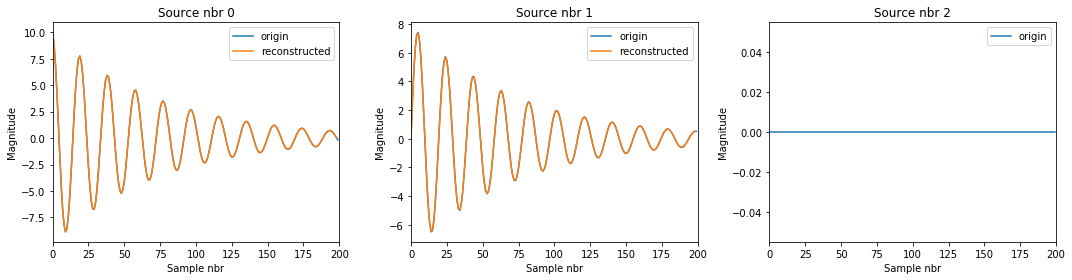

In [10]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p-1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [11]:
for i in range(m_p, n_t - m_p):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

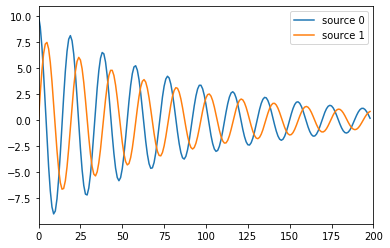

In [12]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Example 2: iSDR order 3

## Initialize MVAR model

In [13]:
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)

## Run iSDR

In [15]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=[1e-3, 1])
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp)
R = cl.coef_

## Compute eigenvalues of MVAR model

In [16]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.935803,0.314422
eig_1,0.935803,-0.314422
eig_2,-0.723980,0.629955
eig_3,-0.723980,-0.629955
eig_4,-0.194797,0.938604
eig_5,-0.194797,-0.938604


## Plot effective connectivity

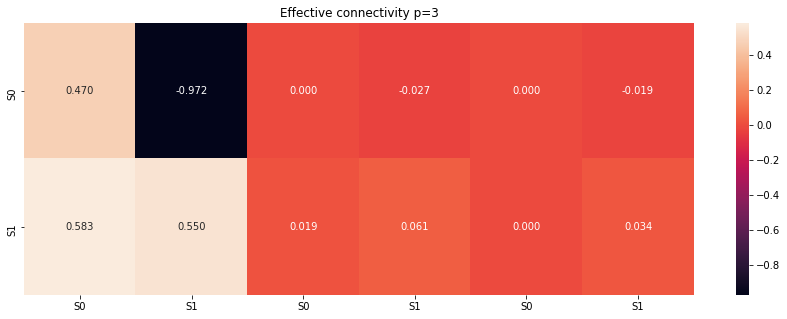

In [17]:
cl.plot_effective()

## Reconstruct the brain activation

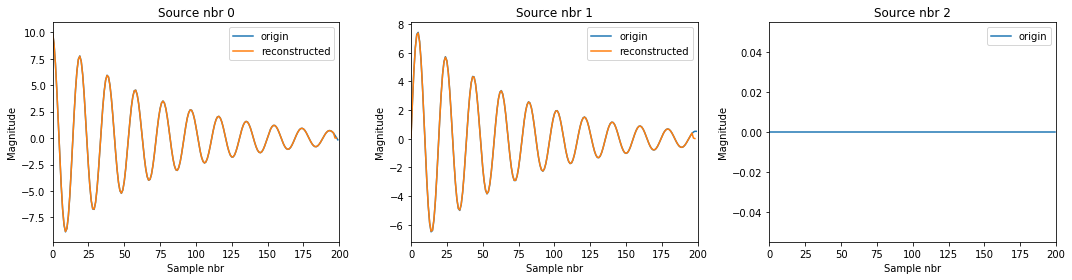

In [18]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p - 1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [19]:
for i in range(m_p, R.shape[1]):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

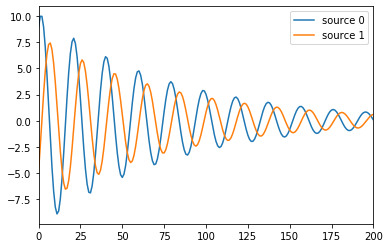

In [20]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Cross-validation iSDR:  grid-search

## Load iSDRcv

In [6]:
from iSDR_cython import linear_model

In [28]:
clf = linear_model.iSDRcv(l21_values=[10**-i for i in range(-1, 6, 1)],
                          la_values=[10**-i for i in range(-1, 5,1)], la_ratio_values=[1, 0.5, 0.75, 0.25], normalize=[0, 1],
                          model_p=[1,2,3])

## Created random folder

In [29]:
clf.foldername

'/tmp/tmp_c0b378de-5cfc-424d-8f7f-7151d20ba02e'

## Run grid cross validation

In [ ]:
clf.run(G, M, SC)

## Results

In [31]:
df = clf.results

In [32]:
df.Obj.min()

3.988311667302084

## Parameters resulting to smallest Obj

In [33]:
x  = df[df.Obj == df.Obj.min()]

In [34]:
x

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,Obj
997,3.979251,2,76.90857,2.519475,1.972707,0.0001,0.001,0.25,1,0,3.988312


## Reconstruct with optimal parameters

In [35]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]])
cl.solver(G, M, SC, nbr_iter=10, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.coef_

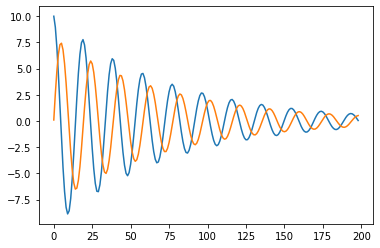

In [36]:
plt.plot(cl.coef_.T)

## Reconstructed effective connectivity

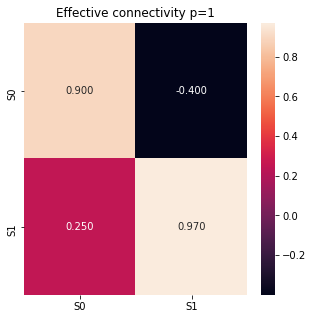

In [37]:
cl.plot_effective()

## Reconstructed dynamics

In [38]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.934871,0.314176
eig_1,0.934871,-0.314176


# Real data

We are using EEG data acquired during famous face recognition task. we should see an activation around 170 ms in the fusiform area

In [6]:
from scipy.io import loadmat

In [7]:
data = loadmat('S1_p1_EEGT800.mat')

In [8]:
fs = 1/np.diff(data['time'])[0][0]

## L1 prior on MVAR

In [11]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-11, 1], verbose=1)
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), nbr_iter=10, model_p=2, A=None, normalize=False)
R = cl.coef_*1e-12

Iteration 0: nbr of active sources 562
Iteration 1: nbr of active sources 95
Iteration 2: nbr of active sources 57
Iteration 3: nbr of active sources 52


### Brain reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

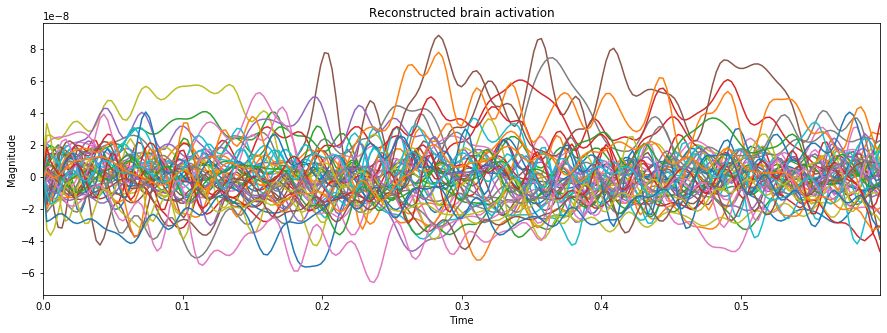

In [12]:
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (Sparse)

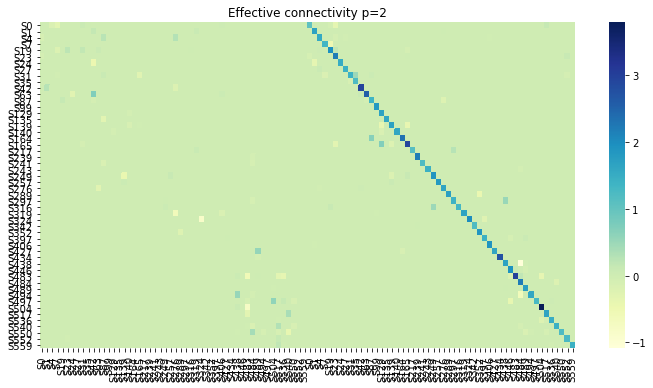

In [13]:
cl.plot_effective(fig_size=6, annot=False, cmap="YlGnBu")

### Left fusiform area

In [14]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

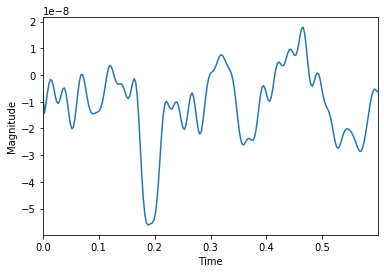

In [15]:
plt.plot(time, 1e-12*cl.coef_[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')

## L2 prior on MVAR

In [ ]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-12, 0], verbose=1)
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), nbr_iter=10, model_p=2, A=None, normalize=False)
R = cl.coef_*1e-12

### Brain activation reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

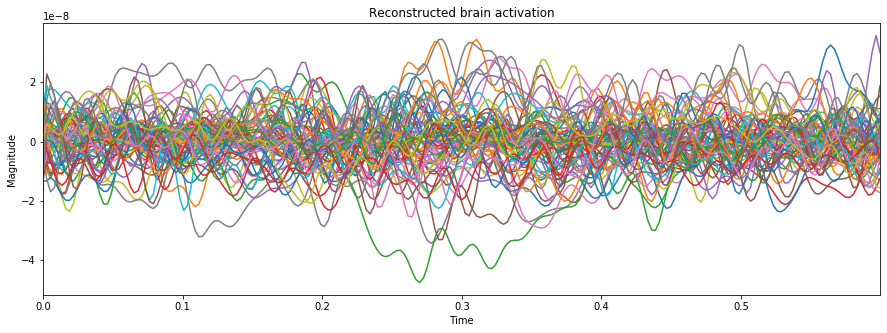

In [42]:
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (less sparse) 

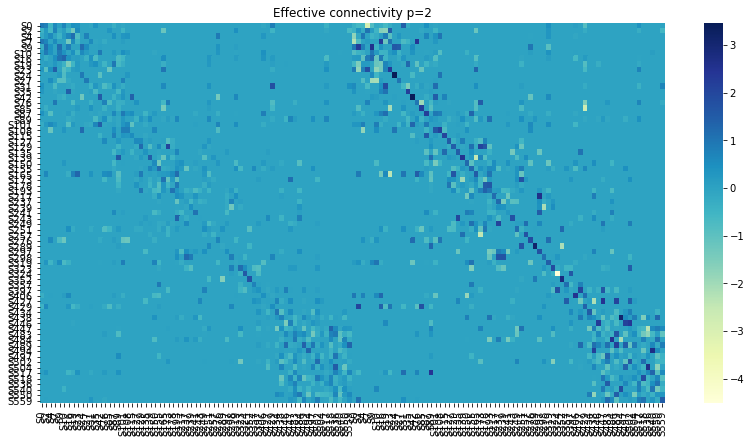

In [43]:
cl.plot_effective(fig_size=7, annot=False, cmap="YlGnBu")

### Left fusiform area

In [44]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

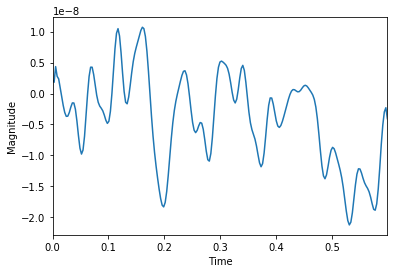

In [48]:
plt.plot(time, 1e-12*cl.coef_[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')